In [2]:
# import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import cv2
import math
import torch
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import numpy as np
import matplotlib.colorbar as colorbar

import requests
from io import BytesIO
from PIL import Image
import numpy as np
from maskrcnn_benchmark.utils import cv2_util
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

from moviepy.editor import VideoFileClip

# this makes our figures bigger
pylab.rcParams['figure.figsize'] = 20*1.5, 12*1.5

from maskrcnn_benchmark.config import cfg
from maskrcnn_benchmark.structures.keypoint import keypoints_to_heat_map
from maskrcnn_benchmark.modeling.roi_heads.keypoint_head.loss import project_keypoints_to_heatmap
from predictor import COCODemo

In [3]:
def load(img_path):
    """
    Given an url of an image, downloads the image and
    returns a PIL image
    """
    
    pil_image = Image.open(img_path).convert("RGB")
    # convert to BGR format
    image = np.array(pil_image)[:, :, [2, 1, 0]]
    return image

def load_video(video_path,frame_id=[0]):
    """
    Given an url of an image, downloads the image and
    returns a PIL image
    """
    
    video_clip = VideoFileClip(video_path)
    if frame_id is None:
        nframes = int(video_clip.fps * video_clip.duration)
        frame_id = range(nframes)
    images = []
    for i in frame_id:
        image = video_clip.get_frame(i/video_clip.fps)
        # convert to BGR format
        image = np.array(image)[:, :, [2, 1, 0]]
        images += [image]
    video_clip.close()
    
    return images

def imshow(img):
    plt.gca().invert_yaxis()
    plt.imshow(img[:, :, [2, 1, 0]])
    plt.axis("off")
    
def sigmoid(x):
  return 1 / (1 + math.exp(-x))
# define vectorized sigmoid
sigmoid_v = np.vectorize(sigmoid)

# num keypoints per animal, heatmap
def calculate_peaks(numparts, heatmap_avg):
    score = np.ones((numparts,)) * 0.000001
    all_peaks = []
    peak_counter = 0
    if len(score) < numparts:
        score = score[:numparts]
        print("score", score)
        ##logger.ERROR(‘Not enough scores provided for number of parts’)
        # return
    # threshold_detection = params[‘thre1’]
    # tic_localmax=time.time()
    for part in range(numparts):
        map_ori = heatmap_avg[part, :, :]
        map = map_ori
        map_left = np.zeros(map.shape)
        map_left[1:, :] = map[:-1, :]
        map_right = np.zeros(map.shape)
        map_right[:-1, :] = map[1:, :]
        map_up = np.zeros(map.shape)
        map_up[:, 1:] = map[:, :-1]
        map_down = np.zeros(map.shape)
        map_down[:, :-1] = map[:, 1:]
        #peaks_binary = np.logical_and(np.logical_and(np.logical_and(map >= map_left, map >= map_right),
                                                     #np.logical_and(map >= map_up, map >= map_down)), map > score[part])
        peaks_binary = (sigmoid_v(map_ori) > .2)
        #print("pb shap", np.shape(peaks_binary))
        peaks = list(zip(np.nonzero(peaks_binary)[1], np.nonzero(peaks_binary)[0]))  # note reverse
        peaks_with_score_and_id = [x + (map_ori[x[1], x[0]], i + peak_counter,) for i, x in
                                   enumerate(peaks)]  # if x[0]>0 and x[1]>0 ]
        all_peaks.append(peaks_with_score_and_id)
        peak_counter += len(peaks)
    return all_peaks



In [4]:
params = {
    'text.latex.preamble': ['\\usepackage{gensymb}'],
    'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'image.cmap': 'jet',
    'axes.grid': False,
    'savefig.dpi': 150,  # to adjust notebook inline plot size
    'axes.labelsize': 10, # fontsize for x and y labels (was 10)
    'axes.titlesize': 12,
    'font.size': 12, # was 10
    'legend.fontsize': 10, # was 10
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    #'text.usetex': True,
    'figure.figsize': [20, 12],
    'font.family': 'serif',
}
matplotlib.rcParams.update(params)

In [5]:
def overlay_keypoints(image, predictions):
        #keypoints = predictions.get_field("keypoints")
        kps = predictions#keypoints.keypoints
        scores = kps.new_ones((kps.size(0), kps.size(1)))
        kps = torch.cat((kps[:, :, 0:2], scores[:, :, None]), dim=2).numpy()
        for region in kps:
            kfun = BeeKeypoints
            image = vis_keypoints_others(
                    image,
                    region.transpose((1, 0)),
                    kp_thresh=0,
                    kfun=kfun)
                
        return image


In [6]:
import cv2
import torch
from torchvision import transforms as T

from maskrcnn_benchmark.modeling.detector import build_detection_model
from maskrcnn_benchmark.utils.checkpoint import DetectronCheckpointer
from maskrcnn_benchmark.structures.image_list import to_image_list
from maskrcnn_benchmark.modeling.roi_heads.mask_head.inference import Masker
from maskrcnn_benchmark import layers as L
from maskrcnn_benchmark.utils import cv2_util

import numpy as np
import matplotlib.pyplot as plt
from maskrcnn_benchmark.structures.keypoint import PersonKeypoints, BeeKeypoints, FlyKeypoints


def vis_keypoints_others(img, kps, kp_thresh=2, alpha=0.7, kfun=PersonKeypoints):
    """Visualizes keypoints (adapted from vis_one_image).
    kps has shape (4, #keypoints) where 4 rows are (x, y, logit, prob).
    """
    img = img.copy()
    dataset_keypoints = kfun.NAMES
    kp_lines = kfun.CONNECTIONS

    # Convert from plt 0-1 RGBA colors to 0-255 BGR colors for opencv.
    cmap = plt.get_cmap('rainbow')
    colors = [cmap(i) for i in np.linspace(0, 1, len(kp_lines) + 2)]
    colors = [(c[2] * 255, c[1] * 255, c[0] * 255) for c in colors]

    # Perform the drawing on a copy of the image, to allow for blending.
    kp_mask = np.copy(img)
    
    # Draw the keypoints.
    for l in [0]:#range(len(kp_lines)):
        i1 = kp_lines[l][0]
        i2 = kp_lines[l][1]
        p1 = kps[0, i1], kps[1, i1]
        p2 = kps[0, i2], kps[1, i2]
        #if kps[2, i1] > kp_thresh and kps[2, i2] > kp_thresh:
         #   cv2.line(
          #      kp_mask, p1, p2,
           #     color=colors[l], thickness=2, lineType=cv2.LINE_AA)
        if kps[2, i1] > kp_thresh:
            cv2.circle(
                kp_mask, p1,
                radius=16, color=colors[l], thickness=-1, lineType=cv2.LINE_AA)
        #if kps[2, i2] > kp_thresh:
         #   cv2.circle(
          #      kp_mask, p2,
           #     radius=16, color=colors[l], thickness=-1, lineType=cv2.LINE_AA)

    # Blend the keypoints.
    return cv2.addWeighted(img, 1.0 - alpha, kp_mask, alpha, 0)

def bounding_box(points):
    x_coordinates, y_coordinates = zip(*points)
    return [min(x_coordinates), min(y_coordinates), max(x_coordinates), max(y_coordinates)]

def get_centroid(coord):
    return [(coord[0]+coord[2])/2, (coord[1]+coord[3])/2]

def get_dist(p1, p2):
    dist = math.hypot(p2[0] - p1[0], p2[1] - p1[1])
    return dist


In [10]:
tr = ['001706223600.jpg', '017062312000.jpg', '017062326400.jpg', '017062238291.jpg', '017062150068.jpg']
t5 = [1706223600, 17062312000, 17062326400, 17062238291, 17062150068]
#test_file = 'bee_test.png'
#image = load(test_file)
#base = "../tools/datasets/bee/validation/"
base = "../tools/datasets/bee/train/"
#base_val = "../tools/datasets/bee/annotations/validation.json"
base_val = "../tools/datasets/bee/annotations/train_bee_annotations2018.json"

import json
with open(base_val) as f:
    data_an = json.load(f)
    for p in data_an['images'][:]:
        if (p['id'] not in t5):
            data_an['images'].remove(p)
    for p in data_an['annotations'][:]:
        if (p['image_id'] not in t5):
            data_an['annotations'].remove(p)
        
#test_ims = 
test_files = ['001706223600.jpg', '017062312000.jpg', '017062326400.jpg', '017062238291.jpg', '017062150068.jpg']
#for p in data_an['images'][:]:
 #   test_files.append(str(p['file_name']))

print(test_files)
print(len(test_files))
test_images = []
for file in test_files:
    test_images.append(load(base + file))



['001706223600.jpg', '017062312000.jpg', '017062326400.jpg', '017062238291.jpg', '017062150068.jpg']
5


1000 it
TARGETS:  None
feats:  5
feats:  1
feats:  256
SHAPE THING torch.Size([1, 10, 100, 180])
SHAPE THING torch.Size([1, 10, 50, 90])
SHAPE THING torch.Size([1, 10, 25, 45])
k labels
v tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
k scores
v tensor([0.0821, 0.0741, 0.0625, 0.0473, 0.3596, 0.6083, 0.5160, 0.1216, 0.3903,
        0.7329, 0.6511, 0.1359, 0.2015, 0.3245, 0.2918, 0.0854],
       device='cuda:0')
k keypoints
v tensor([[[893.1353, 718.6893,   1.0000],
         [923.6573, 638.1693,   1.0000],
         [906.8784, 682.9563,   1.0000],
         [905.5294, 612.0476,   1.0000],
         [952.5789, 617.7208,   1.0000]],

        [[895.0154, 716.8264,   1.0000],
         [925.0304, 637.1812,   1.0000],
         [908.5591, 680.8145,   1.0000],
         [906.9229, 611.4011,   1.0000],
         [954.5356, 615.5922,   1.0000]],

        [[894.4888, 714.8839,   1.0000],
         [924.6349, 637.3545,   1.0000],
         [909.0148, 679.6732,   1.0000],
       

IDDD fn 001706223600.jpg
IDDD fn 001706223600.jpg
1706223600
IDDD 234
IDDD 235
IDDD 236
IDDD 237
IDDD 238
IDDD 239
IDDD 240
IDDD 241
IDDD 242
IDDD 243
IDDD 244
IDDD 245
IDDD 246
IDDD 234
IDDD 235
IDDD 236
IDDD 237
IDDD 238
IDDD 239
IDDD 240
IDDD 241
IDDD 242
IDDD 243
IDDD 244
IDDD 245
IDDD 246
TARGETS:  None
feats:  5
feats:  1
feats:  256
SHAPE THING torch.Size([1, 10, 100, 180])
SHAPE THING torch.Size([1, 10, 50, 90])
SHAPE THING torch.Size([1, 10, 25, 45])
k labels
v tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

IDDD fn 017062312000.jpg
IDDD fn 017062312000.jpg
17062312000
IDDD 580
IDDD 581
IDDD 582
IDDD 583
IDDD 584
IDDD 585
IDDD 586
IDDD 587
IDDD 588
IDDD 589
IDDD 590
IDDD 591
IDDD 592
IDDD 593
IDDD 594
IDDD 595
IDDD 596
IDDD 597
IDDD 598
IDDD 599
IDDD 600
IDDD 601
IDDD 602
IDDD 603
IDDD 604
IDDD 605
IDDD 606
IDDD 607
IDDD 608
IDDD 580
IDDD 581
IDDD 582
IDDD 583
IDDD 584
IDDD 585
IDDD 586
IDDD 587
IDDD 588
IDDD 589
IDDD 590
IDDD 591
IDDD 592
IDDD 593
IDDD 594
IDDD 595
IDDD 596
IDDD 597
IDDD 598
IDDD 599
IDDD 600
IDDD 601
IDDD 602
IDDD 603
IDDD 604
IDDD 605
IDDD 606
IDDD 607
IDDD 608
TARGETS:  None
feats:  5
feats:  1
feats:  256
SHAPE THING torch.Size([1, 10, 100, 180])
SHAPE THING torch.Size([1, 10, 50, 90])
SHAPE THING torch.Size([1, 10, 25, 45])
k labels
v tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

IDDD fn 017062326400.jpg
IDDD fn 017062326400.jpg
17062326400
IDDD 766
IDDD 767
IDDD 768
IDDD 769
IDDD 770
IDDD 771
IDDD 772
IDDD 773
IDDD 774
IDDD 775
IDDD 776
IDDD 777
IDDD 778
IDDD 779
IDDD 780
IDDD 781
IDDD 782
IDDD 783
IDDD 784
IDDD 785
IDDD 786
IDDD 787
IDDD 766
IDDD 767
IDDD 768
IDDD 769
IDDD 770
IDDD 771
IDDD 772
IDDD 773
IDDD 774
IDDD 775
IDDD 776
IDDD 777
IDDD 778
IDDD 779
IDDD 780
IDDD 781
IDDD 782
IDDD 783
IDDD 784
IDDD 785
IDDD 786
IDDD 787
TARGETS:  None
feats:  5
feats:  1
feats:  256
SHAPE THING torch.Size([1, 10, 100, 180])
SHAPE THING torch.Size([1, 10, 50, 90])
SHAPE THING torch.Size([1, 10, 25, 45])
k labels
v tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
k scores
v tensor([0.0434, 0.0602, 0.0540, 0.0312, 0.0334, 0.0491, 0.0424, 0.0273, 0.0382,
        0.2025, 0.2353, 0.1725, 0.0287, 0.0407, 0.0388, 0.0401, 0.0655, 0.5228,
        0.6698, 0.5224, 0.0636, 0.0590, 

IDDD fn 017062238291.jpg
IDDD fn 017062238291.jpg
17062238291
IDDD 876
IDDD 877
IDDD 878
IDDD 879
IDDD 880
IDDD 881
IDDD 882
IDDD 883
IDDD 884
IDDD 885
IDDD 876
IDDD 877
IDDD 878
IDDD 879
IDDD 880
IDDD 881
IDDD 882
IDDD 883
IDDD 884
IDDD 885
TARGETS:  None
feats:  5
feats:  1
feats:  256
SHAPE THING torch.Size([1, 10, 100, 180])
SHAPE THING torch.Size([1, 10, 50, 90])
SHAPE THING torch.Size([1, 10, 25, 45])
k labels
v tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
k scores
v tensor([0.0374, 0.0459, 0.0268, 0.0253, 0.0228, 0.0261, 0.0368, 0.0310, 0.0300,
        0.0184, 0.0225, 0.0169, 0.0834, 0.1700, 0.0218, 0.0282, 0.0099, 0.1305,
        0.4817, 0.0172, 0.0267, 0.1069, 0.5794, 0.0104, 0.0475, 0.0486, 0.0362,
        0.0502, 0.3642, 0.0097, 0.0238, 0.2656, 0.4050, 0.2615, 0.0246, 0.0138,
        0.

IDDD fn 017062150068.jpg
IDDD fn 017062150068.jpg
17062150068
IDDD 1204
IDDD 1205
IDDD 1206
IDDD 1207
IDDD 1208
IDDD 1209
IDDD 1210
IDDD 1211
IDDD 1212
IDDD 1204
IDDD 1205
IDDD 1206
IDDD 1207
IDDD 1208
IDDD 1209
IDDD 1210
IDDD 1211
IDDD 1212
mse total for all images [716.9605871469068, 13395.00507854932, 1107.0029062161234, 472.572367886323, 6652.987135577826]
22344.5280753765
mse yo 4468.9056150753
2000 it
TARGETS:  None
feats:  5
feats:  1
feats:  256
SHAPE THING torch.Size([1, 10, 100, 180])
SHAPE THING torch.Size([1, 10, 50, 90])
SHAPE THING torch.Size([1, 10, 25, 45])
k labels
v tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
k scores
v tensor([0.0459, 0.0841, 0.0757, 0.0621, 0.0436, 0.3843, 0.6412, 0.5357, 0.1118,
        0.4050, 0.7412, 0.6525, 0.1255, 0.1895, 0.2976, 0.2667, 0.0725],
       device='cuda:0')
k keypoints
v tensor([[[457.0140, 183.9281,   1.0000],
         [527.3141, 296.5645,   1.0000],
         [494.7059, 253.7143,   1.0000],
       

IDDD fn 001706223600.jpg
IDDD fn 001706223600.jpg
1706223600
IDDD 234
IDDD 235
IDDD 236
IDDD 237
IDDD 238
IDDD 239
IDDD 240
IDDD 241
IDDD 242
IDDD 243
IDDD 244
IDDD 245
IDDD 246
IDDD 234
IDDD 235
IDDD 236
IDDD 237
IDDD 238
IDDD 239
IDDD 240
IDDD 241
IDDD 242
IDDD 243
IDDD 244
IDDD 245
IDDD 246
TARGETS:  None
feats:  5
feats:  1
feats:  256
SHAPE THING torch.Size([1, 10, 100, 180])
SHAPE THING torch.Size([1, 10, 50, 90])
SHAPE THING torch.Size([1, 10, 25, 45])
k labels
v tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

IDDD fn 017062312000.jpg
IDDD fn 017062312000.jpg
17062312000
IDDD 580
IDDD 581
IDDD 582
IDDD 583
IDDD 584
IDDD 585
IDDD 586
IDDD 587
IDDD 588
IDDD 589
IDDD 590
IDDD 591
IDDD 592
IDDD 593
IDDD 594
IDDD 595
IDDD 596
IDDD 597
IDDD 598
IDDD 599
IDDD 600
IDDD 601
IDDD 602
IDDD 603
IDDD 604
IDDD 605
IDDD 606
IDDD 607
IDDD 608
IDDD 580
IDDD 581
IDDD 582
IDDD 583
IDDD 584
IDDD 585
IDDD 586
IDDD 587
IDDD 588
IDDD 589
IDDD 590
IDDD 591
IDDD 592
IDDD 593
IDDD 594
IDDD 595
IDDD 596
IDDD 597
IDDD 598
IDDD 599
IDDD 600
IDDD 601
IDDD 602
IDDD 603
IDDD 604
IDDD 605
IDDD 606
IDDD 607
IDDD 608
TARGETS:  None
feats:  5
feats:  1
feats:  256
SHAPE THING torch.Size([1, 10, 100, 180])
SHAPE THING torch.Size([1, 10, 50, 90])
SHAPE THING torch.Size([1, 10, 25, 45])
k labels
v tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

IDDD fn 017062326400.jpg
IDDD fn 017062326400.jpg
17062326400
IDDD 766
IDDD 767
IDDD 768
IDDD 769
IDDD 770
IDDD 771
IDDD 772
IDDD 773
IDDD 774
IDDD 775
IDDD 776
IDDD 777
IDDD 778
IDDD 779
IDDD 780
IDDD 781
IDDD 782
IDDD 783
IDDD 784
IDDD 785
IDDD 786
IDDD 787
IDDD 766
IDDD 767
IDDD 768
IDDD 769
IDDD 770
IDDD 771
IDDD 772
IDDD 773
IDDD 774
IDDD 775
IDDD 776
IDDD 777
IDDD 778
IDDD 779
IDDD 780
IDDD 781
IDDD 782
IDDD 783
IDDD 784
IDDD 785
IDDD 786
IDDD 787
TARGETS:  None
feats:  5
feats:  1
feats:  256
SHAPE THING torch.Size([1, 10, 100, 180])
SHAPE THING torch.Size([1, 10, 50, 90])
SHAPE THING torch.Size([1, 10, 25, 45])
k labels
v tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
k scores
v tensor([0.0348, 0.0513, 0.0484, 0.0285, 0.0393, 0.0344, 0.0350, 0.2200, 0.2610,
        0.1864, 0.0314, 0.0414, 0.0565, 0.5265, 0.6982, 0.5483, 0.0710, 0.0465,
        0.0892, 0.1879, 0.0629, 0.1202, 0.1361, 0.1376, 0.

IDDD fn 017062238291.jpg
IDDD fn 017062238291.jpg
17062238291
IDDD 876
IDDD 877
IDDD 878
IDDD 879
IDDD 880
IDDD 881
IDDD 882
IDDD 883
IDDD 884
IDDD 885
IDDD 876
IDDD 877
IDDD 878
IDDD 879
IDDD 880
IDDD 881
IDDD 882
IDDD 883
IDDD 884
IDDD 885
TARGETS:  None
feats:  5
feats:  1
feats:  256
SHAPE THING torch.Size([1, 10, 100, 180])
SHAPE THING torch.Size([1, 10, 50, 90])
SHAPE THING torch.Size([1, 10, 25, 45])
k labels
v tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
k scores
v tensor([0.0349, 0.0437, 0.0266, 0.0232, 0.0245, 0.0353, 0.0316, 0.0332, 0.0188,
        0.0218, 0.0167, 0.0765, 0.1811, 0.0224, 0.0087, 0.1086, 0.4984, 0.0174,
        0.0831, 0.6021, 0.0111, 0.0504, 0.0518, 0.0389, 0.0381, 0.3810, 0.0102,
        0.0282, 0.2831, 0.4274, 0.2891, 0.0261, 0.0101, 0.0652, 0.0233, 0.2217,
        0.3278, 0.2372, 0

IDDD fn 017062150068.jpg
IDDD fn 017062150068.jpg
17062150068
IDDD 1204
IDDD 1205
IDDD 1206
IDDD 1207
IDDD 1208
IDDD 1209
IDDD 1210
IDDD 1211
IDDD 1212
IDDD 1204
IDDD 1205
IDDD 1206
IDDD 1207
IDDD 1208
IDDD 1209
IDDD 1210
IDDD 1211
IDDD 1212
mse total for all images [595.7899828894431, 13399.584938701866, 1056.8963340262585, 436.9980391175926, 6967.8177101975925]
22457.08700493275
mse yo 4491.41740098655
3000 it
TARGETS:  None
feats:  5
feats:  1
feats:  256
SHAPE THING torch.Size([1, 10, 100, 180])
SHAPE THING torch.Size([1, 10, 50, 90])
SHAPE THING torch.Size([1, 10, 25, 45])
k labels
v tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
k scores
v tensor([0.0769, 0.0603, 0.0466, 0.0340, 0.3865, 0.6240, 0.5170, 0.1073, 0.4085,
        0.7409, 0.6583, 0.1310, 0.1747, 0.2714, 0.2408, 0.0677],
       device='cuda:0')
k keypoints
v tensor([[[892.2994, 720.7192,   1.0000],
         [922.7103, 638.8340,   1.0000],
         [906.6384, 683.5806,   1.0000],
         [905

IDDD fn 001706223600.jpg
IDDD fn 001706223600.jpg
1706223600
IDDD 234
IDDD 235
IDDD 236
IDDD 237
IDDD 238
IDDD 239
IDDD 240
IDDD 241
IDDD 242
IDDD 243
IDDD 244
IDDD 245
IDDD 246
IDDD 234
IDDD 235
IDDD 236
IDDD 237
IDDD 238
IDDD 239
IDDD 240
IDDD 241
IDDD 242
IDDD 243
IDDD 244
IDDD 245
IDDD 246
TARGETS:  None
feats:  5
feats:  1
feats:  256
SHAPE THING torch.Size([1, 10, 100, 180])
SHAPE THING torch.Size([1, 10, 50, 90])
SHAPE THING torch.Size([1, 10, 25, 45])
k labels
v tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

IDDD fn 017062312000.jpg
IDDD fn 017062312000.jpg
17062312000
IDDD 580
IDDD 581
IDDD 582
IDDD 583
IDDD 584
IDDD 585
IDDD 586
IDDD 587
IDDD 588
IDDD 589
IDDD 590
IDDD 591
IDDD 592
IDDD 593
IDDD 594
IDDD 595
IDDD 596
IDDD 597
IDDD 598
IDDD 599
IDDD 600
IDDD 601
IDDD 602
IDDD 603
IDDD 604
IDDD 605
IDDD 606
IDDD 607
IDDD 608
IDDD 580
IDDD 581
IDDD 582
IDDD 583
IDDD 584
IDDD 585
IDDD 586
IDDD 587
IDDD 588
IDDD 589
IDDD 590
IDDD 591
IDDD 592
IDDD 593
IDDD 594
IDDD 595
IDDD 596
IDDD 597
IDDD 598
IDDD 599
IDDD 600
IDDD 601
IDDD 602
IDDD 603
IDDD 604
IDDD 605
IDDD 606
IDDD 607
IDDD 608
TARGETS:  None
feats:  5
feats:  1
feats:  256
SHAPE THING torch.Size([1, 10, 100, 180])
SHAPE THING torch.Size([1, 10, 50, 90])
SHAPE THING torch.Size([1, 10, 25, 45])
k labels
v tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

IDDD fn 017062326400.jpg
IDDD fn 017062326400.jpg
17062326400
IDDD 766
IDDD 767
IDDD 768
IDDD 769
IDDD 770
IDDD 771
IDDD 772
IDDD 773
IDDD 774
IDDD 775
IDDD 776
IDDD 777
IDDD 778
IDDD 779
IDDD 780
IDDD 781
IDDD 782
IDDD 783
IDDD 784
IDDD 785
IDDD 786
IDDD 787
IDDD 766
IDDD 767
IDDD 768
IDDD 769
IDDD 770
IDDD 771
IDDD 772
IDDD 773
IDDD 774
IDDD 775
IDDD 776
IDDD 777
IDDD 778
IDDD 779
IDDD 780
IDDD 781
IDDD 782
IDDD 783
IDDD 784
IDDD 785
IDDD 786
IDDD 787
TARGETS:  None
feats:  5
feats:  1
feats:  256
SHAPE THING torch.Size([1, 10, 100, 180])
SHAPE THING torch.Size([1, 10, 50, 90])
SHAPE THING torch.Size([1, 10, 25, 45])
k labels
v tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
k scores
v tensor([0.0324, 0.0482, 0.0451, 0.0377, 0.0315, 0.0316, 0.1744, 0.1982, 0.1475,
        0.0305, 0.0424, 0.0621, 0.5251, 0.6852, 0.5327, 0.0733, 0.0398, 0.0815,
        0.1901, 0.0658, 0.1248, 0.1394, 0.1404

IDDD fn 017062238291.jpg
IDDD fn 017062238291.jpg
17062238291
IDDD 876
IDDD 877
IDDD 878
IDDD 879
IDDD 880
IDDD 881
IDDD 882
IDDD 883
IDDD 884
IDDD 885
IDDD 876
IDDD 877
IDDD 878
IDDD 879
IDDD 880
IDDD 881
IDDD 882
IDDD 883
IDDD 884
IDDD 885
TARGETS:  None
feats:  5
feats:  1
feats:  256
SHAPE THING torch.Size([1, 10, 100, 180])
SHAPE THING torch.Size([1, 10, 50, 90])
SHAPE THING torch.Size([1, 10, 25, 45])
k labels
v tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
k scores
v tensor([0.0330, 0.0432, 0.0260, 0.0231, 0.0227, 0.0327, 0.0288, 0.0321, 0.0172,
        0.0160, 0.0757, 0.1812, 0.0208, 0.0259, 0.0081, 0.1059, 0.4907, 0.0149,
        0.0798, 0.5967, 0.0094, 0.0378, 0.0425, 0.0436, 0.0332, 0.0361, 0.3816,
        0.0091, 0.0289, 0.2703, 0.3999, 0.2659, 0.0219, 0.0090, 0.0625, 0.0227,
        0.2040, 0.2949, 0.2131, 0.

IDDD fn 017062150068.jpg
IDDD fn 017062150068.jpg
17062150068
IDDD 1204
IDDD 1205
IDDD 1206
IDDD 1207
IDDD 1208
IDDD 1209
IDDD 1210
IDDD 1211
IDDD 1212
IDDD 1204
IDDD 1205
IDDD 1206
IDDD 1207
IDDD 1208
IDDD 1209
IDDD 1210
IDDD 1211
IDDD 1212
mse total for all images [532.4779857344245, 13428.680781588979, 1001.3049790075403, 448.0846860269323, 3059.677809007647]
18470.226241365523
mse yo 3694.0452482731043
4000 it
TARGETS:  None
feats:  5
feats:  1
feats:  256
SHAPE THING torch.Size([1, 10, 100, 180])
SHAPE THING torch.Size([1, 10, 50, 90])
SHAPE THING torch.Size([1, 10, 25, 45])
k labels
v tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
k scores
v tensor([0.0763, 0.0575, 0.0427, 0.0336, 0.3917, 0.6341, 0.5293, 0.1129, 0.4055,
        0.7426, 0.6619, 0.1321, 0.1724, 0.2620, 0.2274, 0.0626],
       device='cuda:0')
k keypoints
v tensor([[[891.6801, 720.5601,   1.0000],
         [922.9078, 638.7653,   1.0000],
         [906.6500, 683.7084,   1.0000],
         [9

IDDD fn 001706223600.jpg
IDDD fn 001706223600.jpg
1706223600
IDDD 234
IDDD 235
IDDD 236
IDDD 237
IDDD 238
IDDD 239
IDDD 240
IDDD 241
IDDD 242
IDDD 243
IDDD 244
IDDD 245
IDDD 246
IDDD 234
IDDD 235
IDDD 236
IDDD 237
IDDD 238
IDDD 239
IDDD 240
IDDD 241
IDDD 242
IDDD 243
IDDD 244
IDDD 245
IDDD 246
TARGETS:  None
feats:  5
feats:  1
feats:  256
SHAPE THING torch.Size([1, 10, 100, 180])
SHAPE THING torch.Size([1, 10, 50, 90])
SHAPE THING torch.Size([1, 10, 25, 45])
k labels
v tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

IDDD fn 017062312000.jpg
IDDD fn 017062312000.jpg
17062312000
IDDD 580
IDDD 581
IDDD 582
IDDD 583
IDDD 584
IDDD 585
IDDD 586
IDDD 587
IDDD 588
IDDD 589
IDDD 590
IDDD 591
IDDD 592
IDDD 593
IDDD 594
IDDD 595
IDDD 596
IDDD 597
IDDD 598
IDDD 599
IDDD 600
IDDD 601
IDDD 602
IDDD 603
IDDD 604
IDDD 605
IDDD 606
IDDD 607
IDDD 608
IDDD 580
IDDD 581
IDDD 582
IDDD 583
IDDD 584
IDDD 585
IDDD 586
IDDD 587
IDDD 588
IDDD 589
IDDD 590
IDDD 591
IDDD 592
IDDD 593
IDDD 594
IDDD 595
IDDD 596
IDDD 597
IDDD 598
IDDD 599
IDDD 600
IDDD 601
IDDD 602
IDDD 603
IDDD 604
IDDD 605
IDDD 606
IDDD 607
IDDD 608
TARGETS:  None
feats:  5
feats:  1
feats:  256
SHAPE THING torch.Size([1, 10, 100, 180])
SHAPE THING torch.Size([1, 10, 50, 90])
SHAPE THING torch.Size([1, 10, 25, 45])
k labels
v tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

IDDD fn 017062326400.jpg
IDDD fn 017062326400.jpg
17062326400
IDDD 766
IDDD 767
IDDD 768
IDDD 769
IDDD 770
IDDD 771
IDDD 772
IDDD 773
IDDD 774
IDDD 775
IDDD 776
IDDD 777
IDDD 778
IDDD 779
IDDD 780
IDDD 781
IDDD 782
IDDD 783
IDDD 784
IDDD 785
IDDD 786
IDDD 787
IDDD 766
IDDD 767
IDDD 768
IDDD 769
IDDD 770
IDDD 771
IDDD 772
IDDD 773
IDDD 774
IDDD 775
IDDD 776
IDDD 777
IDDD 778
IDDD 779
IDDD 780
IDDD 781
IDDD 782
IDDD 783
IDDD 784
IDDD 785
IDDD 786
IDDD 787
TARGETS:  None
feats:  5
feats:  1
feats:  256
SHAPE THING torch.Size([1, 10, 100, 180])
SHAPE THING torch.Size([1, 10, 50, 90])
SHAPE THING torch.Size([1, 10, 25, 45])
k labels
v tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
k scores
v tensor([0.0374, 0.0365, 0.0298, 0.1654, 0.1818, 0.1373, 0.0447, 0.0605, 0.5317,
        0.6868, 0.5374, 0.0686, 0.0739, 0.1875, 0.0620, 0.1177, 0.1288, 0.1372,
        0.0279, 0.0616, 0.1924, 0.1132, 0.0450, 0.1363, 0.

IDDD fn 017062238291.jpg
IDDD fn 017062238291.jpg
17062238291
IDDD 876
IDDD 877
IDDD 878
IDDD 879
IDDD 880
IDDD 881
IDDD 882
IDDD 883
IDDD 884
IDDD 885
IDDD 876
IDDD 877
IDDD 878
IDDD 879
IDDD 880
IDDD 881
IDDD 882
IDDD 883
IDDD 884
IDDD 885
TARGETS:  None
feats:  5
feats:  1
feats:  256
SHAPE THING torch.Size([1, 10, 100, 180])
SHAPE THING torch.Size([1, 10, 50, 90])
SHAPE THING torch.Size([1, 10, 25, 45])
k labels
v tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
k scores
v tensor([0.0315, 0.0402, 0.0232, 0.0225, 0.0319, 0.0148, 0.0692, 0.1896, 0.0219,
        0.0899, 0.4996, 0.0161, 0.0645, 0.6054, 0.0103, 0.0412, 0.0310, 0.0296,
        0.3896, 0.0096, 0.0292, 0.2741, 0.3961, 0.2849, 0.0259, 0.0608, 0.0221,
        0.1857, 0.2543, 0.2012, 0.0354, 0.0339, 0.1976, 0.2164, 0.2166, 0.0498,
        0.5073, 0.6788, 0.5744, 0.0506, 0.2971, 0.4237, 0.3974, 0.0450,

IDDD fn 017062150068.jpg
IDDD fn 017062150068.jpg
17062150068
IDDD 1204
IDDD 1205
IDDD 1206
IDDD 1207
IDDD 1208
IDDD 1209
IDDD 1210
IDDD 1211
IDDD 1212
IDDD 1204
IDDD 1205
IDDD 1206
IDDD 1207
IDDD 1208
IDDD 1209
IDDD 1210
IDDD 1211
IDDD 1212
mse total for all images [523.1637174117809, 13466.94846044863, 1007.5577750725287, 423.55717304260145, 2840.654362104201]
18261.88148807974
mse yo 3652.376297615948
5000 it
TARGETS:  None
feats:  5
feats:  1
feats:  256
SHAPE THING torch.Size([1, 10, 100, 180])
SHAPE THING torch.Size([1, 10, 50, 90])
SHAPE THING torch.Size([1, 10, 25, 45])
k labels
v tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
k scores
v tensor([0.0762, 0.0554, 0.0409, 0.0341, 0.3928, 0.6455, 0.5398, 0.1158, 0.3969,
        0.7359, 0.6531, 0.1295, 0.1564, 0.2296, 0.1977, 0.0559],
       device='cuda:0')
k keypoints
v tensor([[[892.1005, 721.0720,   1.0000],
         [923.0693, 638.8901,   1.0000],
         [906.8661, 683.8038,   1.0000],
         [907

IDDD fn 001706223600.jpg
IDDD fn 001706223600.jpg
1706223600
IDDD 234
IDDD 235
IDDD 236
IDDD 237
IDDD 238
IDDD 239
IDDD 240
IDDD 241
IDDD 242
IDDD 243
IDDD 244
IDDD 245
IDDD 246
IDDD 234
IDDD 235
IDDD 236
IDDD 237
IDDD 238
IDDD 239
IDDD 240
IDDD 241
IDDD 242
IDDD 243
IDDD 244
IDDD 245
IDDD 246
TARGETS:  None
feats:  5
feats:  1
feats:  256
SHAPE THING torch.Size([1, 10, 100, 180])
SHAPE THING torch.Size([1, 10, 50, 90])
SHAPE THING torch.Size([1, 10, 25, 45])
k labels
v tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

IDDD fn 017062312000.jpg
IDDD fn 017062312000.jpg
17062312000
IDDD 580
IDDD 581
IDDD 582
IDDD 583
IDDD 584
IDDD 585
IDDD 586
IDDD 587
IDDD 588
IDDD 589
IDDD 590
IDDD 591
IDDD 592
IDDD 593
IDDD 594
IDDD 595
IDDD 596
IDDD 597
IDDD 598
IDDD 599
IDDD 600
IDDD 601
IDDD 602
IDDD 603
IDDD 604
IDDD 605
IDDD 606
IDDD 607
IDDD 608
IDDD 580
IDDD 581
IDDD 582
IDDD 583
IDDD 584
IDDD 585
IDDD 586
IDDD 587
IDDD 588
IDDD 589
IDDD 590
IDDD 591
IDDD 592
IDDD 593
IDDD 594
IDDD 595
IDDD 596
IDDD 597
IDDD 598
IDDD 599
IDDD 600
IDDD 601
IDDD 602
IDDD 603
IDDD 604
IDDD 605
IDDD 606
IDDD 607
IDDD 608
TARGETS:  None
feats:  5
feats:  1
feats:  256
SHAPE THING torch.Size([1, 10, 100, 180])
SHAPE THING torch.Size([1, 10, 50, 90])
SHAPE THING torch.Size([1, 10, 25, 45])
k labels
v tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

IDDD fn 017062326400.jpg
IDDD fn 017062326400.jpg
17062326400
IDDD 766
IDDD 767
IDDD 768
IDDD 769
IDDD 770
IDDD 771
IDDD 772
IDDD 773
IDDD 774
IDDD 775
IDDD 776
IDDD 777
IDDD 778
IDDD 779
IDDD 780
IDDD 781
IDDD 782
IDDD 783
IDDD 784
IDDD 785
IDDD 786
IDDD 787
IDDD 766
IDDD 767
IDDD 768
IDDD 769
IDDD 770
IDDD 771
IDDD 772
IDDD 773
IDDD 774
IDDD 775
IDDD 776
IDDD 777
IDDD 778
IDDD 779
IDDD 780
IDDD 781
IDDD 782
IDDD 783
IDDD 784
IDDD 785
IDDD 786
IDDD 787
TARGETS:  None
feats:  5
feats:  1
feats:  256
SHAPE THING torch.Size([1, 10, 100, 180])
SHAPE THING torch.Size([1, 10, 50, 90])
SHAPE THING torch.Size([1, 10, 25, 45])
k labels
v tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
k scores
v tensor([0.0273, 0.0400, 0.0379, 0.0312, 0.0326, 0.1916, 0.2081, 0.1511, 0.0405,
        0.0535, 0.0620, 0.5528, 0.7226, 0.5514, 0.0618, 0.0766, 0.2053, 0.0601,
        0.13

IDDD fn 017062238291.jpg
IDDD fn 017062238291.jpg
17062238291
IDDD 876
IDDD 877
IDDD 878
IDDD 879
IDDD 880
IDDD 881
IDDD 882
IDDD 883
IDDD 884
IDDD 885
IDDD 876
IDDD 877
IDDD 878
IDDD 879
IDDD 880
IDDD 881
IDDD 882
IDDD 883
IDDD 884
IDDD 885
TARGETS:  None
feats:  5
feats:  1
feats:  256
SHAPE THING torch.Size([1, 10, 100, 180])
SHAPE THING torch.Size([1, 10, 50, 90])
SHAPE THING torch.Size([1, 10, 25, 45])
k labels
v tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1], device='cuda:0')
k scores
v tensor([0.0323, 0.0431, 0.0257, 0.0226, 0.0249, 0.0233, 0.0334, 0.0150, 0.0739,
        0.1943, 0.0210, 0.0277, 0.0993, 0.4957, 0.0145, 0.0241, 0.0333, 0.0737,
        0.5955, 0.0093, 0.0388, 0.0290, 0.0350, 0.3737, 0.0093, 0.0315, 0.2467,
        0.3526, 0.2503, 0.0206, 0.0085, 0.0571, 0.0229, 0.1601, 0.2121, 0.1672,
        0.0287, 0.0443, 0.2552, 0.2807, 0.2651, 0.04

IDDD fn 017062150068.jpg
IDDD fn 017062150068.jpg
17062150068
IDDD 1204
IDDD 1205
IDDD 1206
IDDD 1207
IDDD 1208
IDDD 1209
IDDD 1210
IDDD 1211
IDDD 1212
IDDD 1204
IDDD 1205
IDDD 1206
IDDD 1207
IDDD 1208
IDDD 1209
IDDD 1210
IDDD 1211
IDDD 1212
mse total for all images [507.00056722205437, 13482.725568042148, 976.8522188510332, 421.08640594030686, 2609.3274984984655]
17996.992258554004
mse yo 3599.398451710801
6000 it
TARGETS:  None
feats:  5
feats:  1
feats:  256
SHAPE THING torch.Size([1, 10, 100, 180])
SHAPE THING torch.Size([1, 10, 50, 90])
SHAPE THING torch.Size([1, 10, 25, 45])
k labels
v tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
k scores
v tensor([0.0814, 0.0626, 0.0472, 0.0361, 0.3944, 0.6659, 0.5640, 0.1227, 0.3817,
        0.7262, 0.6551, 0.1340, 0.1378, 0.2054, 0.1777, 0.0546],
       device='cuda:0')
k keypoints
v tensor([[[891.4670, 721.7409,   1.0000],
         [923.0667, 638.9491,   1.0000],
         [906.4055, 683.7667,   1.0000],
         [

IDDD fn 001706223600.jpg
IDDD fn 001706223600.jpg
1706223600
IDDD 234
IDDD 235
IDDD 236
IDDD 237
IDDD 238
IDDD 239
IDDD 240
IDDD 241
IDDD 242
IDDD 243
IDDD 244
IDDD 245
IDDD 246
IDDD 234
IDDD 235
IDDD 236
IDDD 237
IDDD 238
IDDD 239
IDDD 240
IDDD 241
IDDD 242
IDDD 243
IDDD 244
IDDD 245
IDDD 246
TARGETS:  None
feats:  5
feats:  1
feats:  256
SHAPE THING torch.Size([1, 10, 100, 180])
SHAPE THING torch.Size([1, 10, 50, 90])
SHAPE THING torch.Size([1, 10, 25, 45])
k labels
v tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

IDDD fn 017062312000.jpg
IDDD fn 017062312000.jpg
17062312000
IDDD 580
IDDD 581
IDDD 582
IDDD 583
IDDD 584
IDDD 585
IDDD 586
IDDD 587
IDDD 588
IDDD 589
IDDD 590
IDDD 591
IDDD 592
IDDD 593
IDDD 594
IDDD 595
IDDD 596
IDDD 597
IDDD 598
IDDD 599
IDDD 600
IDDD 601
IDDD 602
IDDD 603
IDDD 604
IDDD 605
IDDD 606
IDDD 607
IDDD 608
IDDD 580
IDDD 581
IDDD 582
IDDD 583
IDDD 584
IDDD 585
IDDD 586
IDDD 587
IDDD 588
IDDD 589
IDDD 590
IDDD 591
IDDD 592
IDDD 593
IDDD 594
IDDD 595
IDDD 596
IDDD 597
IDDD 598
IDDD 599
IDDD 600
IDDD 601
IDDD 602
IDDD 603
IDDD 604
IDDD 605
IDDD 606
IDDD 607
IDDD 608
TARGETS:  None
feats:  5
feats:  1
feats:  256
SHAPE THING torch.Size([1, 10, 100, 180])
SHAPE THING torch.Size([1, 10, 50, 90])
SHAPE THING torch.Size([1, 10, 25, 45])
k labels
v tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

IDDD fn 017062326400.jpg
IDDD fn 017062326400.jpg
17062326400
IDDD 766
IDDD 767
IDDD 768
IDDD 769
IDDD 770
IDDD 771
IDDD 772
IDDD 773
IDDD 774
IDDD 775
IDDD 776
IDDD 777
IDDD 778
IDDD 779
IDDD 780
IDDD 781
IDDD 782
IDDD 783
IDDD 784
IDDD 785
IDDD 786
IDDD 787
IDDD 766
IDDD 767
IDDD 768
IDDD 769
IDDD 770
IDDD 771
IDDD 772
IDDD 773
IDDD 774
IDDD 775
IDDD 776
IDDD 777
IDDD 778
IDDD 779
IDDD 780
IDDD 781
IDDD 782
IDDD 783
IDDD 784
IDDD 785
IDDD 786
IDDD 787
TARGETS:  None
feats:  5
feats:  1
feats:  256
SHAPE THING torch.Size([1, 10, 100, 180])
SHAPE THING torch.Size([1, 10, 50, 90])
SHAPE THING torch.Size([1, 10, 25, 45])
k labels
v tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1], device='cuda:0')
k scores
v tensor([0.0385, 0.0373, 0.0306, 0.1956, 0.2179, 0.1588, 0.0389, 0.0543, 0.0578,
        0.5536, 0.7287, 0.5643, 0.0670, 0.0613, 0.1815, 0.0579, 0.1290, 0.1480,
        0.1609, 0.0276, 0.0467, 0.1639, 0.0962, 0.1081, 0.1137, 0.0

IDDD fn 017062238291.jpg
IDDD fn 017062238291.jpg
17062238291
IDDD 876
IDDD 877
IDDD 878
IDDD 879
IDDD 880
IDDD 881
IDDD 882
IDDD 883
IDDD 884
IDDD 885
IDDD 876
IDDD 877
IDDD 878
IDDD 879
IDDD 880
IDDD 881
IDDD 882
IDDD 883
IDDD 884
IDDD 885
TARGETS:  None
feats:  5
feats:  1
feats:  256
SHAPE THING torch.Size([1, 10, 100, 180])
SHAPE THING torch.Size([1, 10, 50, 90])
SHAPE THING torch.Size([1, 10, 25, 45])
k labels
v tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
k scores
v tensor([0.0310, 0.0396, 0.0241, 0.0225, 0.0303, 0.0183, 0.0182, 0.0792, 0.2055,
        0.0210, 0.1003, 0.4929, 0.0130, 0.0715, 0.5793, 0.0078, 0.0417, 0.0305,
        0.0325, 0.3547, 0.0077, 0.0386, 0.2683, 0.3726, 0.2611, 0.0198, 0.0536,
        0.0242, 0.1404, 0.1785, 0.1501, 0.2310, 0.2570, 0.2430, 0.0452, 0.5305,
        0.7244, 0.5855, 0.3211, 0.4604, 0.4094, 0.0493], device='cuda:0')
k keypoints
v

IDDD fn 017062150068.jpg
IDDD fn 017062150068.jpg
17062150068
IDDD 1204
IDDD 1205
IDDD 1206
IDDD 1207
IDDD 1208
IDDD 1209
IDDD 1210
IDDD 1211
IDDD 1212
IDDD 1204
IDDD 1205
IDDD 1206
IDDD 1207
IDDD 1208
IDDD 1209
IDDD 1210
IDDD 1211
IDDD 1212
mse total for all images [485.92088462408776, 13498.306332450173, 975.1808429350534, 401.90545793987974, 2874.139757822528]
18235.45327577172
mse yo 3647.090655154344
7000 it
TARGETS:  None
feats:  5
feats:  1
feats:  256
SHAPE THING torch.Size([1, 10, 100, 180])
SHAPE THING torch.Size([1, 10, 50, 90])
SHAPE THING torch.Size([1, 10, 25, 45])
k labels
v tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
k scores
v tensor([0.0703, 0.0486, 0.0362, 0.0327, 0.3937, 0.6629, 0.5649, 0.1258, 0.3901,
        0.7497, 0.6795, 0.1377, 0.1447, 0.2239, 0.1932, 0.0555, 0.0399, 0.0403,
        0.0392], device='cuda:0')
k keypoints
v tensor([[[891.5990, 721.5645,   1.0000],
         [922.7074, 639.5781,   1.0000],
         [90

IDDD fn 001706223600.jpg
IDDD fn 001706223600.jpg
1706223600
IDDD 234
IDDD 235
IDDD 236
IDDD 237
IDDD 238
IDDD 239
IDDD 240
IDDD 241
IDDD 242
IDDD 243
IDDD 244
IDDD 245
IDDD 246
IDDD 234
IDDD 235
IDDD 236
IDDD 237
IDDD 238
IDDD 239
IDDD 240
IDDD 241
IDDD 242
IDDD 243
IDDD 244
IDDD 245
IDDD 246
TARGETS:  None
feats:  5
feats:  1
feats:  256
SHAPE THING torch.Size([1, 10, 100, 180])
SHAPE THING torch.Size([1, 10, 50, 90])
SHAPE THING torch.Size([1, 10, 25, 45])
k labels
v tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

IDDD fn 017062312000.jpg
IDDD fn 017062312000.jpg
17062312000
IDDD 580
IDDD 581
IDDD 582
IDDD 583
IDDD 584
IDDD 585
IDDD 586
IDDD 587
IDDD 588
IDDD 589
IDDD 590
IDDD 591
IDDD 592
IDDD 593
IDDD 594
IDDD 595
IDDD 596
IDDD 597
IDDD 598
IDDD 599
IDDD 600
IDDD 601
IDDD 602
IDDD 603
IDDD 604
IDDD 605
IDDD 606
IDDD 607
IDDD 608
IDDD 580
IDDD 581
IDDD 582
IDDD 583
IDDD 584
IDDD 585
IDDD 586
IDDD 587
IDDD 588
IDDD 589
IDDD 590
IDDD 591
IDDD 592
IDDD 593
IDDD 594
IDDD 595
IDDD 596
IDDD 597
IDDD 598
IDDD 599
IDDD 600
IDDD 601
IDDD 602
IDDD 603
IDDD 604
IDDD 605
IDDD 606
IDDD 607
IDDD 608
TARGETS:  None
feats:  5
feats:  1
feats:  256
SHAPE THING torch.Size([1, 10, 100, 180])
SHAPE THING torch.Size([1, 10, 50, 90])
SHAPE THING torch.Size([1, 10, 25, 45])
k labels
v tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

IDDD fn 017062326400.jpg
IDDD fn 017062326400.jpg
17062326400
IDDD 766
IDDD 767
IDDD 768
IDDD 769
IDDD 770
IDDD 771
IDDD 772
IDDD 773
IDDD 774
IDDD 775
IDDD 776
IDDD 777
IDDD 778
IDDD 779
IDDD 780
IDDD 781
IDDD 782
IDDD 783
IDDD 784
IDDD 785
IDDD 786
IDDD 787
IDDD 766
IDDD 767
IDDD 768
IDDD 769
IDDD 770
IDDD 771
IDDD 772
IDDD 773
IDDD 774
IDDD 775
IDDD 776
IDDD 777
IDDD 778
IDDD 779
IDDD 780
IDDD 781
IDDD 782
IDDD 783
IDDD 784
IDDD 785
IDDD 786
IDDD 787
TARGETS:  None
feats:  5
feats:  1
feats:  256
SHAPE THING torch.Size([1, 10, 100, 180])
SHAPE THING torch.Size([1, 10, 50, 90])
SHAPE THING torch.Size([1, 10, 25, 45])
k labels
v tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
k scores
v tensor([0.0301, 0.0439, 0.0405, 0.0328, 0.0273, 0.0285, 0.1678, 0.1784, 0.1324,
        0.0404, 0.0586, 0.0579, 0.5645, 0.7417, 0.5636, 0.0589, 0.0678, 0.1964,
        0

IDDD fn 017062238291.jpg
IDDD fn 017062238291.jpg
17062238291
IDDD 876
IDDD 877
IDDD 878
IDDD 879
IDDD 880
IDDD 881
IDDD 882
IDDD 883
IDDD 884
IDDD 885
IDDD 876
IDDD 877
IDDD 878
IDDD 879
IDDD 880
IDDD 881
IDDD 882
IDDD 883
IDDD 884
IDDD 885
TARGETS:  None
feats:  5
feats:  1
feats:  256
SHAPE THING torch.Size([1, 10, 100, 180])
SHAPE THING torch.Size([1, 10, 50, 90])
SHAPE THING torch.Size([1, 10, 25, 45])
k labels
v tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
k scores
v tensor([0.0321, 0.0416, 0.0243, 0.0239, 0.0229, 0.0326, 0.0163, 0.0662, 0.1930,
        0.0229, 0.0249, 0.0808, 0.5059, 0.0161, 0.0556, 0.6063, 0.0105, 0.0358,
        0.0272, 0.3821, 0.0102, 0.0365, 0.2576, 0.3518, 0.2527, 0.0557, 0.0225,
        0.1351, 0.1695, 0.1464, 0.2272, 0.2674, 0.2689, 0.5111, 0.7321, 0.6248,
        0.0399, 0.3027, 0.4649, 0.4411, 0.0466], device='cuda:0')
k keypoints
v tensor([[[

IDDD fn 017062150068.jpg
IDDD fn 017062150068.jpg
17062150068
IDDD 1204
IDDD 1205
IDDD 1206
IDDD 1207
IDDD 1208
IDDD 1209
IDDD 1210
IDDD 1211
IDDD 1212
IDDD 1204
IDDD 1205
IDDD 1206
IDDD 1207
IDDD 1208
IDDD 1209
IDDD 1210
IDDD 1211
IDDD 1212
mse total for all images [490.8681285768935, 13482.129375202228, 950.907961425346, 401.9138940209756, 2413.7760016641705]
17739.595360889616
mse yo 3547.919072177923
8000 it
TARGETS:  None
feats:  5
feats:  1
feats:  256
SHAPE THING torch.Size([1, 10, 100, 180])
SHAPE THING torch.Size([1, 10, 50, 90])
SHAPE THING torch.Size([1, 10, 25, 45])
k labels
v tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
k scores
v tensor([0.0840, 0.0599, 0.0465, 0.0376, 0.4150, 0.6908, 0.5783, 0.1091, 0.4090,
        0.7573, 0.6712, 0.1128, 0.1512, 0.2175, 0.1887, 0.0479, 0.0407, 0.0412,
        0.0389], device='cuda:0')
k keypoints
v tensor([[[891.3889, 721.7668,   1.0000],
         [922.6970, 639.6608,   1.0000],
         [906

IDDD fn 001706223600.jpg
IDDD fn 001706223600.jpg
1706223600
IDDD 234
IDDD 235
IDDD 236
IDDD 237
IDDD 238
IDDD 239
IDDD 240
IDDD 241
IDDD 242
IDDD 243
IDDD 244
IDDD 245
IDDD 246
IDDD 234
IDDD 235
IDDD 236
IDDD 237
IDDD 238
IDDD 239
IDDD 240
IDDD 241
IDDD 242
IDDD 243
IDDD 244
IDDD 245
IDDD 246
TARGETS:  None
feats:  5
feats:  1
feats:  256
SHAPE THING torch.Size([1, 10, 100, 180])
SHAPE THING torch.Size([1, 10, 50, 90])
SHAPE THING torch.Size([1, 10, 25, 45])
k labels
v tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

IDDD fn 017062312000.jpg
IDDD fn 017062312000.jpg
17062312000
IDDD 580
IDDD 581
IDDD 582
IDDD 583
IDDD 584
IDDD 585
IDDD 586
IDDD 587
IDDD 588
IDDD 589
IDDD 590
IDDD 591
IDDD 592
IDDD 593
IDDD 594
IDDD 595
IDDD 596
IDDD 597
IDDD 598
IDDD 599
IDDD 600
IDDD 601
IDDD 602
IDDD 603
IDDD 604
IDDD 605
IDDD 606
IDDD 607
IDDD 608
IDDD 580
IDDD 581
IDDD 582
IDDD 583
IDDD 584
IDDD 585
IDDD 586
IDDD 587
IDDD 588
IDDD 589
IDDD 590
IDDD 591
IDDD 592
IDDD 593
IDDD 594
IDDD 595
IDDD 596
IDDD 597
IDDD 598
IDDD 599
IDDD 600
IDDD 601
IDDD 602
IDDD 603
IDDD 604
IDDD 605
IDDD 606
IDDD 607
IDDD 608
TARGETS:  None
feats:  5
feats:  1
feats:  256
SHAPE THING torch.Size([1, 10, 100, 180])
SHAPE THING torch.Size([1, 10, 50, 90])
SHAPE THING torch.Size([1, 10, 25, 45])
k labels
v tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

IDDD fn 017062326400.jpg
IDDD fn 017062326400.jpg
17062326400
IDDD 766
IDDD 767
IDDD 768
IDDD 769
IDDD 770
IDDD 771
IDDD 772
IDDD 773
IDDD 774
IDDD 775
IDDD 776
IDDD 777
IDDD 778
IDDD 779
IDDD 780
IDDD 781
IDDD 782
IDDD 783
IDDD 784
IDDD 785
IDDD 786
IDDD 787
IDDD 766
IDDD 767
IDDD 768
IDDD 769
IDDD 770
IDDD 771
IDDD 772
IDDD 773
IDDD 774
IDDD 775
IDDD 776
IDDD 777
IDDD 778
IDDD 779
IDDD 780
IDDD 781
IDDD 782
IDDD 783
IDDD 784
IDDD 785
IDDD 786
IDDD 787
TARGETS:  None
feats:  5
feats:  1
feats:  256
SHAPE THING torch.Size([1, 10, 100, 180])
SHAPE THING torch.Size([1, 10, 50, 90])
SHAPE THING torch.Size([1, 10, 25, 45])
k labels
v tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
k scores
v tensor([0.0305, 0.0447, 0.0415, 0.0333, 0.1826, 0.1941, 0.1439, 0.0524, 0.0522,
        0.5634, 0.7397, 0.5647, 0.0588, 0.0705, 0.2024, 0.0524, 0.1403, 0.1691,
        0.1767, 0.028

IDDD fn 017062238291.jpg
IDDD fn 017062238291.jpg
17062238291
IDDD 876
IDDD 877
IDDD 878
IDDD 879
IDDD 880
IDDD 881
IDDD 882
IDDD 883
IDDD 884
IDDD 885
IDDD 876
IDDD 877
IDDD 878
IDDD 879
IDDD 880
IDDD 881
IDDD 882
IDDD 883
IDDD 884
IDDD 885
TARGETS:  None
feats:  5
feats:  1
feats:  256
SHAPE THING torch.Size([1, 10, 100, 180])
SHAPE THING torch.Size([1, 10, 50, 90])
SHAPE THING torch.Size([1, 10, 25, 45])
k labels
v tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
k scores
v tensor([0.0309, 0.0414, 0.0235, 0.0218, 0.0320, 0.0265, 0.0196, 0.0212, 0.0753,
        0.1946, 0.0253, 0.0304, 0.0960, 0.5070, 0.0184, 0.0269, 0.0672, 0.5947,
        0.0115, 0.0384, 0.0313, 0.3656, 0.0111, 0.0355, 0.2232, 0.2914, 0.2267,
        0.0495, 0.1270, 0.1557, 0.1419, 0.1719, 0.1869, 0.1703, 0.4836, 0.6826,
        0.5526, 0.2747, 0.4263, 0.3969, 0.0461], device='cuda:0')
k keypoints
v tensor([[[

IDDD fn 017062150068.jpg
IDDD fn 017062150068.jpg
17062150068
IDDD 1204
IDDD 1205
IDDD 1206
IDDD 1207
IDDD 1208
IDDD 1209
IDDD 1210
IDDD 1211
IDDD 1212
IDDD 1204
IDDD 1205
IDDD 1206
IDDD 1207
IDDD 1208
IDDD 1209
IDDD 1210
IDDD 1211
IDDD 1212
mse total for all images [486.13615597530645, 13566.194058939003, 921.560618256361, 419.12341585937577, 2427.9945615694264]
17821.008810599473
mse yo 3564.2017621198947
9000 it
TARGETS:  None
feats:  5
feats:  1
feats:  256
SHAPE THING torch.Size([1, 10, 100, 180])
SHAPE THING torch.Size([1, 10, 50, 90])
SHAPE THING torch.Size([1, 10, 25, 45])
k labels
v tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
k scores
v tensor([0.0848, 0.0601, 0.0448, 0.0325, 0.4112, 0.6897, 0.5893, 0.1168, 0.3909,
        0.7450, 0.6832, 0.1358, 0.1261, 0.1916, 0.1684, 0.0525],
       device='cuda:0')
k keypoints
v tensor([[[890.9537, 721.4956,   1.0000],
         [922.3234, 639.8457,   1.0000],
         [906.3378, 684.4576,   1.0000],
         [

IDDD fn 001706223600.jpg
IDDD fn 001706223600.jpg
1706223600
IDDD 234
IDDD 235
IDDD 236
IDDD 237
IDDD 238
IDDD 239
IDDD 240
IDDD 241
IDDD 242
IDDD 243
IDDD 244
IDDD 245
IDDD 246
IDDD 234
IDDD 235
IDDD 236
IDDD 237
IDDD 238
IDDD 239
IDDD 240
IDDD 241
IDDD 242
IDDD 243
IDDD 244
IDDD 245
IDDD 246
TARGETS:  None
feats:  5
feats:  1
feats:  256
SHAPE THING torch.Size([1, 10, 100, 180])
SHAPE THING torch.Size([1, 10, 50, 90])
SHAPE THING torch.Size([1, 10, 25, 45])
k labels
v tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

IDDD fn 017062312000.jpg
IDDD fn 017062312000.jpg
17062312000
IDDD 580
IDDD 581
IDDD 582
IDDD 583
IDDD 584
IDDD 585
IDDD 586
IDDD 587
IDDD 588
IDDD 589
IDDD 590
IDDD 591
IDDD 592
IDDD 593
IDDD 594
IDDD 595
IDDD 596
IDDD 597
IDDD 598
IDDD 599
IDDD 600
IDDD 601
IDDD 602
IDDD 603
IDDD 604
IDDD 605
IDDD 606
IDDD 607
IDDD 608
IDDD 580
IDDD 581
IDDD 582
IDDD 583
IDDD 584
IDDD 585
IDDD 586
IDDD 587
IDDD 588
IDDD 589
IDDD 590
IDDD 591
IDDD 592
IDDD 593
IDDD 594
IDDD 595
IDDD 596
IDDD 597
IDDD 598
IDDD 599
IDDD 600
IDDD 601
IDDD 602
IDDD 603
IDDD 604
IDDD 605
IDDD 606
IDDD 607
IDDD 608
TARGETS:  None
feats:  5
feats:  1
feats:  256
SHAPE THING torch.Size([1, 10, 100, 180])
SHAPE THING torch.Size([1, 10, 50, 90])
SHAPE THING torch.Size([1, 10, 25, 45])
k labels
v tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

IDDD fn 017062326400.jpg
IDDD fn 017062326400.jpg
17062326400
IDDD 766
IDDD 767
IDDD 768
IDDD 769
IDDD 770
IDDD 771
IDDD 772
IDDD 773
IDDD 774
IDDD 775
IDDD 776
IDDD 777
IDDD 778
IDDD 779
IDDD 780
IDDD 781
IDDD 782
IDDD 783
IDDD 784
IDDD 785
IDDD 786
IDDD 787
IDDD 766
IDDD 767
IDDD 768
IDDD 769
IDDD 770
IDDD 771
IDDD 772
IDDD 773
IDDD 774
IDDD 775
IDDD 776
IDDD 777
IDDD 778
IDDD 779
IDDD 780
IDDD 781
IDDD 782
IDDD 783
IDDD 784
IDDD 785
IDDD 786
IDDD 787
TARGETS:  None
feats:  5
feats:  1
feats:  256
SHAPE THING torch.Size([1, 10, 100, 180])
SHAPE THING torch.Size([1, 10, 50, 90])
SHAPE THING torch.Size([1, 10, 25, 45])
k labels
v tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1], device='cuda:0')
k scores
v tensor([0.0352, 0.0346, 0.1440, 0.1394, 0.1011, 0.0463, 0.0390, 0.5436, 0.7294,
        0.5673, 0.0720, 0.0591, 0.1764, 0.0534, 0.1461, 0.1804, 0.1865, 0.0359,
        0.1668, 0.1002, 0.1126, 0.1161, 0.0771, 0.0383, 0.0449, 0.0

IDDD fn 017062238291.jpg
IDDD fn 017062238291.jpg
17062238291
IDDD 876
IDDD 877
IDDD 878
IDDD 879
IDDD 880
IDDD 881
IDDD 882
IDDD 883
IDDD 884
IDDD 885
IDDD 876
IDDD 877
IDDD 878
IDDD 879
IDDD 880
IDDD 881
IDDD 882
IDDD 883
IDDD 884
IDDD 885
TARGETS:  None
feats:  5
feats:  1
feats:  256
SHAPE THING torch.Size([1, 10, 100, 180])
SHAPE THING torch.Size([1, 10, 50, 90])
SHAPE THING torch.Size([1, 10, 25, 45])
k labels
v tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
k scores
v tensor([0.0269, 0.0360, 0.0302, 0.0159, 0.0665, 0.1869, 0.0203, 0.0883, 0.5104,
        0.0140, 0.0624, 0.6131, 0.0085, 0.0320, 0.0289, 0.3957, 0.0085, 0.0313,
        0.2478, 0.3331, 0.2489, 0.0532, 0.1289, 0.1599, 0.1447, 0.2305, 0.2661,
        0.2743, 0.0465, 0.5636, 0.7408, 0.6164, 0.3051, 0.4371, 0.4091],
       device='cuda:0')
k keypoints
v tensor([[[739.9414,  32.4419,   1.0000],
         [685.7220,   1.4802,   1.00

IDDD fn 017062150068.jpg
IDDD fn 017062150068.jpg
17062150068
IDDD 1204
IDDD 1205
IDDD 1206
IDDD 1207
IDDD 1208
IDDD 1209
IDDD 1210
IDDD 1211
IDDD 1212
IDDD 1204
IDDD 1205
IDDD 1206
IDDD 1207
IDDD 1208
IDDD 1209
IDDD 1210
IDDD 1211
IDDD 1212
mse total for all images [466.5433242431206, 13515.582337375552, 914.701306703901, 401.0771991461769, 2190.1257808315354]
17488.029948300285
mse yo 3497.6059896600573
10000 it
TARGETS:  None
feats:  5
feats:  1
feats:  256
SHAPE THING torch.Size([1, 10, 100, 180])
SHAPE THING torch.Size([1, 10, 50, 90])
SHAPE THING torch.Size([1, 10, 25, 45])
k labels
v tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
k scores
v tensor([0.0757, 0.0509, 0.0383, 0.0333, 0.3973, 0.6685, 0.5677, 0.1161, 0.3874,
        0.7356, 0.6687, 0.1280, 0.1237, 0.1742, 0.1512, 0.0449],
       device='cuda:0')
k keypoints
v tensor([[[891.1230, 721.6028,   1.0000],
         [922.0944, 639.7287,   1.0000],
         [906.3664, 684.3334,   1.0000],
         [9

IDDD fn 001706223600.jpg
IDDD fn 001706223600.jpg
1706223600
IDDD 234
IDDD 235
IDDD 236
IDDD 237
IDDD 238
IDDD 239
IDDD 240
IDDD 241
IDDD 242
IDDD 243
IDDD 244
IDDD 245
IDDD 246
IDDD 234
IDDD 235
IDDD 236
IDDD 237
IDDD 238
IDDD 239
IDDD 240
IDDD 241
IDDD 242
IDDD 243
IDDD 244
IDDD 245
IDDD 246
TARGETS:  None
feats:  5
feats:  1
feats:  256
SHAPE THING torch.Size([1, 10, 100, 180])
SHAPE THING torch.Size([1, 10, 50, 90])
SHAPE THING torch.Size([1, 10, 25, 45])
k labels
v tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

IDDD fn 017062312000.jpg
IDDD fn 017062312000.jpg
17062312000
IDDD 580
IDDD 581
IDDD 582
IDDD 583
IDDD 584
IDDD 585
IDDD 586
IDDD 587
IDDD 588
IDDD 589
IDDD 590
IDDD 591
IDDD 592
IDDD 593
IDDD 594
IDDD 595
IDDD 596
IDDD 597
IDDD 598
IDDD 599
IDDD 600
IDDD 601
IDDD 602
IDDD 603
IDDD 604
IDDD 605
IDDD 606
IDDD 607
IDDD 608
IDDD 580
IDDD 581
IDDD 582
IDDD 583
IDDD 584
IDDD 585
IDDD 586
IDDD 587
IDDD 588
IDDD 589
IDDD 590
IDDD 591
IDDD 592
IDDD 593
IDDD 594
IDDD 595
IDDD 596
IDDD 597
IDDD 598
IDDD 599
IDDD 600
IDDD 601
IDDD 602
IDDD 603
IDDD 604
IDDD 605
IDDD 606
IDDD 607
IDDD 608
TARGETS:  None
feats:  5
feats:  1
feats:  256
SHAPE THING torch.Size([1, 10, 100, 180])
SHAPE THING torch.Size([1, 10, 50, 90])
SHAPE THING torch.Size([1, 10, 25, 45])
k labels
v tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

IDDD fn 017062326400.jpg
IDDD fn 017062326400.jpg
17062326400
IDDD 766
IDDD 767
IDDD 768
IDDD 769
IDDD 770
IDDD 771
IDDD 772
IDDD 773
IDDD 774
IDDD 775
IDDD 776
IDDD 777
IDDD 778
IDDD 779
IDDD 780
IDDD 781
IDDD 782
IDDD 783
IDDD 784
IDDD 785
IDDD 786
IDDD 787
IDDD 766
IDDD 767
IDDD 768
IDDD 769
IDDD 770
IDDD 771
IDDD 772
IDDD 773
IDDD 774
IDDD 775
IDDD 776
IDDD 777
IDDD 778
IDDD 779
IDDD 780
IDDD 781
IDDD 782
IDDD 783
IDDD 784
IDDD 785
IDDD 786
IDDD 787
TARGETS:  None
feats:  5
feats:  1
feats:  256
SHAPE THING torch.Size([1, 10, 100, 180])
SHAPE THING torch.Size([1, 10, 50, 90])
SHAPE THING torch.Size([1, 10, 25, 45])
k labels
v tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1], device='cuda:0')
k scores
v tensor([0.0338, 0.0334, 0.1575, 0.1596, 0.1206, 0.0516, 0.0390, 0.5586, 0.7414,
        0.5690, 0.0684, 0.0515, 0.1748, 0.0503, 0.1490, 0.1806, 0.1853, 0.0330,
        0.1487, 0.0853, 0.0952, 0.1034, 0.0639, 0.0427, 0.0526, 0.0

IDDD fn 017062238291.jpg
IDDD fn 017062238291.jpg
17062238291
IDDD 876
IDDD 877
IDDD 878
IDDD 879
IDDD 880
IDDD 881
IDDD 882
IDDD 883
IDDD 884
IDDD 885
IDDD 876
IDDD 877
IDDD 878
IDDD 879
IDDD 880
IDDD 881
IDDD 882
IDDD 883
IDDD 884
IDDD 885
TARGETS:  None
feats:  5
feats:  1
feats:  256
SHAPE THING torch.Size([1, 10, 100, 180])
SHAPE THING torch.Size([1, 10, 50, 90])
SHAPE THING torch.Size([1, 10, 25, 45])
k labels
v tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
k scores
v tensor([0.0271, 0.0356, 0.0212, 0.0302, 0.0174, 0.0710, 0.1877, 0.0207, 0.1005,
        0.5123, 0.0141, 0.0752, 0.6107, 0.0085, 0.0340, 0.0349, 0.3924, 0.0089,
        0.0356, 0.2485, 0.3332, 0.2457, 0.0510, 0.1099, 0.1316, 0.1222, 0.1768,
        0.1979, 0.2216, 0.5176, 0.7056, 0.6154, 0.2665, 0.3995, 0.4080],
       device='cuda:0')
k keypoints
v tensor([[[742.8818,  32.7622,   1.0000],
         [685.8342,   2.1491,   1.00

IDDD fn 017062150068.jpg
IDDD fn 017062150068.jpg
17062150068
IDDD 1204
IDDD 1205
IDDD 1206
IDDD 1207
IDDD 1208
IDDD 1209
IDDD 1210
IDDD 1211
IDDD 1212
IDDD 1204
IDDD 1205
IDDD 1206
IDDD 1207
IDDD 1208
IDDD 1209
IDDD 1210
IDDD 1211
IDDD 1212
mse total for all images [469.5242186656553, 13554.750206692608, 917.4311189816918, 410.44120113801694, 2021.9557012967816]
17374.102446774756
mse yo 3474.820489354951


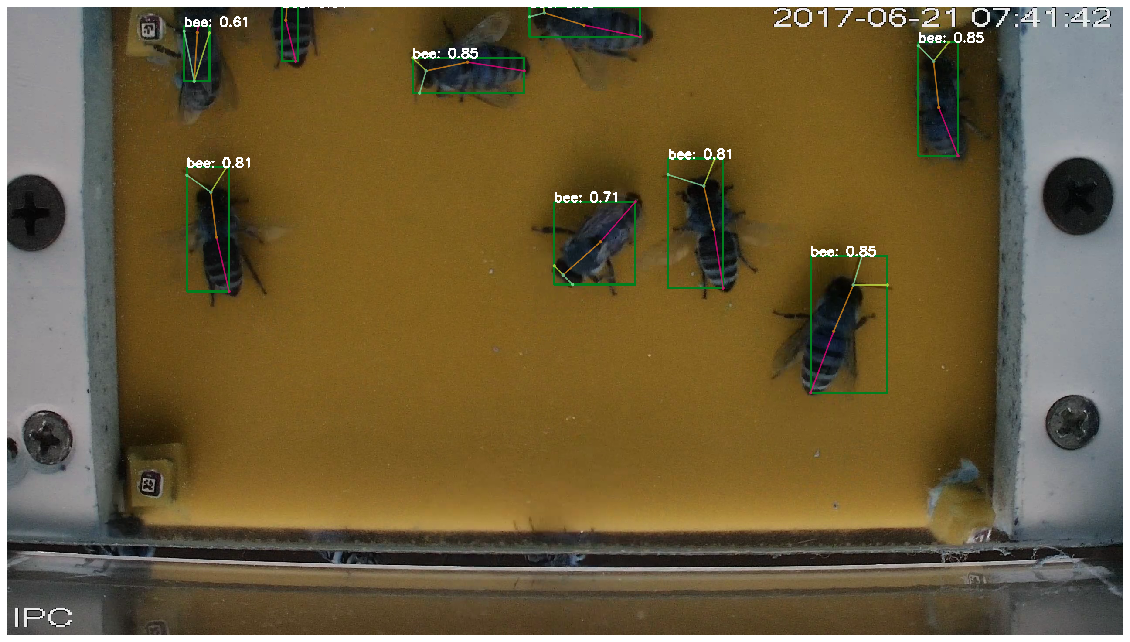

In [26]:
#single mse dp
import matplotlib.gridspec as gridspec
from itertools import chain

data_size = "5"
its = range(1000,10001,1000)
#its = range(2000,6001,1000)
b = "23.1"
v = "2"

#test_ims = []
losses = ["standard_res0/3","p3standard0/3","p2p2combined_res.001/3","p4_ccombined_beta.5/2"]
t = []
#its = [5000]
loss = losses[1]
for it in its:
    print(it,"it")
    if it < 1000:
        it = "0000" + str(it)
    elif it > 9999:
        it = "00" + str(it)
    else:
        it = "000" + str(it)
    config_file = "/home/bsb2144/directpose/configs/fcos/fcos_kps_ms_training_R_50_FPN_1x.yaml"

    cfg.merge_from_file("/home/bsb2144/directpose/configs/fcos/fcos_kps_ms_training_R_50_FPN_1x.yaml")
    cfg.merge_from_list(['DATALOADER.NUM_WORKERS', '2', \
                         'DATATYPE', 'bee', \
                         'OUTPUT_DIR', 'training_dir/' + data_size + '/' + loss +'/fcos_kps_ms_training_R_50_FPN_1x_bee1', \
                         'MODEL.WEIGHT', '/home/bsb2144/directpose/tools/training_dir/' + data_size + '/'+ loss +'/fcos_kps_ms_training_R_50_FPN_1x_bee/model_'+it+'.pth',\
                         'DATASETS.TEST', "('bee_val_cocostyle',)",\
                         'DATASETS.TRAIN', "('bee_train_cocostyle', )",\
                        ])

    coco_demo = COCODemo(
                cfg,
                min_image_size=800,
                confidence_threshold=0.2,
    )


    mse_total = []
    tim = [test_images[0]]
    for idx, image in enumerate(test_images):
        mse_per_bee = []
        predictions, tps, hm_res, stride, hms, targets, c_loss = coco_demo.run_on_opencv_image(image)
        kps = tps.get_field("keypoints").keypoints
        bboxes = tps.bbox
        #print("BBOXES", bboxes)
        #print("KPS",kps)
        plt.gca().invert_yaxis()
        imshow(predictions[:, :, [2, 1, 0]])
        plt.gca().invert_yaxis()

        for p in data_an['images'][:]:
            if (str(p['file_name']) == test_files[idx] ):
                im_id = p['id']  
                print("IDDD fn",p['file_name'])
        print(im_id)
        for p in data_an['annotations'][:]:
            if ((p['image_id']) == im_id ):
                print("IDDD",p['id'])
                #CHANGEfor test
                bb = p["segmentation"]#p['bbox']
                #bb = p['bbox']
                bb = bb[0]
                #print('bb', bb)
                bb_f = [bb[:2], bb[2:4], bb[4:6], bb[6:]]
                #print('bbf', bb_f)
                bbox = bounding_box(bb_f)
                cent_val = get_centroid(bbox)
                dists = []
                #print(cent_val)
                for index, p_bbox in enumerate(bboxes):
                    cp = get_centroid(p_bbox)
                    dist = get_dist(cent_val, cp)
                    dists.append(dist)
                    #print(dist)
                min_idx = dists.index(min(dists))
                #print("min id", min_idx)
                kps_valog = p["keypoints"]
                #print('kps val pre', kps_valog)
                # comment for test and remove og
                kps_val = [x for i, x in enumerate(kps_valog) if (i+1)%3 !=0]
                #print('kps val post', kps_val)
                kps_pred = kps[min_idx].tolist()
                kps_pred_list = [kps_pred[0][:2],kps_pred[1][:2],kps_pred[2][:2],kps_pred[3][:2],kps_pred[4][:2]]
                kps_pl = list(chain.from_iterable(kps_pred_list))
                #print("kps pred", kps_pred)
                #print("kp pred listt", kps_pred_list)
                diff_vec = np.array(kps_val) - np.array(kps_pl)
                #print("diff vec", diff_vec)
                #print(diff_vec*diff_vec)
                diff_vec_sum_sq = np.sum(diff_vec*diff_vec)
                #print(diff_vec_sum_sq)
                mse_per_bee.append(diff_vec_sum_sq)

        mse_per_image = sum(mse_per_bee)
        #print("mse", mse_per_image)
        #print("mse", mse_per_bee)
        mse_final = mse_per_image/len(mse_per_bee)
        mse_total.append(mse_final)
        #print("mse final", mse_final)


        #img3 = predictions[:, :, [2, 1, 0]]
        #b,g,r = cv2.split(img3)       # get b,g,r
        #img3 = cv2.merge([r,g,b])     # switch it to rgb
        #im = axes[idx][2].imshow(img3)
        #axes[idx][2].invert_yaxis()
        #plt.savefig(base_file + '_reg.png')
    print("mse total for all images", mse_total)
    print(sum(mse_total))
    mse_test = sum(mse_total)/len(mse_total)
    t.append(mse_test)
    print("mse yo", mse_test)


In [27]:
print(t)




[4468.9056150753, 4491.41740098655, 3694.0452482731043, 3652.376297615948, 3599.398451710801, 3647.090655154344, 3547.919072177923, 3564.2017621198947, 3497.6059896600573, 3474.820489354951]


In [ ]:
#TRAIN MSES

ts1 = [18404.911255652067, 8627.03336298736, 8073.724265926428, 6759.979076449023, 5129.293931902617, 4605.876082668657, 4551.919816151154, 2084.706595823104, 1987.9569282656284, 1984.8619882887615, 1945.9159207966331, 1971.9204750307586, 4487.098472834848, 1979.133959023056, 1936.0288799547968]
ts2 = [14523.443888401143, 8039.602423531335, 4829.083455594357, 5999.455596560452, 5803.739535433126, 1191.4083129300209, 1143.8373896706662, 1080.5480306562893, 1060.405128186791, 1017.6738763851506, 1663.2125464479334, 1650.4722919701326, 1621.138955504461, 1612.3667447109651, 1578.4067168369088]
ts3 = [36082.90327305319, 6661.19886043126, 6752.035389642403, 6097.138370827085, 4679.7290678118825, 4468.9056150753, 4491.41740098655, 3694.0452482731043, 3652.376297615948, 3599.398451710801, 3647.090655154344, 3547.919072177923, 3564.2017621198947, 3497.6059896600573, 3474.820489354951]

tc1
tc2
tc3

tu1
tu2
tu3



In [137]:
t1 = [15011.76967998355, 15127.667253746225,15665.570764976093, 15344.883332181511,17610.144816393233,14555.191678791203, 15585.610409167772, 17307.3229319881, 17114.891394387996, 17527.586456286426]
t2 = [15382.943912998582,12948.257587140562,12016.622638868774,11491.101955618551,12425.99906523927,10839.633671493944, 12919.162591274291, 12708.99253120122, 11806.68998103495, 13403.728798428376]
t3 = [13199.280021099965, 15313.813209031174,14197.453859275498,13264.627031974394,15264.527539522422,14126.794543411457, 15068.276700619255, 15263.476956058863, 15276.339042771559, 15766.860881127941]

In [146]:
c1 = [12818.812189829803, 21115.75207160644, 21939.2224049479,21077.41764695348, 21404.689861971496, 20077.68914897437, 20322.51991356641, 20221.47242777069,19990.751792321524, 21317.27217303216, 21424.53493544978, 20416.864247708465, 20703.316115657195]
c2 = [16409.297003902524, 15631.583541160957, 19732.613046098322,12430.498084118486, 13409.38787919351, 12851.060188152947, 14108.092715745246, 14045.585077044117,13601.31367920663, 13985.733467832097, 14142.206917764075, 14242.14229101802, 14418.386077405412]
c3 = [18837.259390968087, 17318.993683547153, 15508.415734136688,15135.850211778312, 14797.982779711196, 15360.50103849797, 14600.943342535338, 15486.321149402918,15296.690689438203, 15374.386145050452, 15801.7468552201, 15272.82758039327,15014.601088224083]

In [147]:
s1 = [46481.89381252696, 26158.482211818522, 16077.375775328142, 23747.939040602385, 17666.628491840274,21167.521162300534, 22844.959606785873, 22509.6405317005, 23116.69670684126, 23591.34962707445,22927.335802066005, 22762.856524731113, 24454.230365664574, 23489.713105607545, 22791.382127293466]
s2 = [20774.273260115606, 17145.905416638263, 18696.489346738916, 13911.129585014742, 15491.395701814368,14380.581770966675, 13588.143191137595, 14977.183944227516, 16239.264337870114, 15648.164613716128,15377.905247366563, 15531.891358772215, 16205.456256474446, 14781.610951796145, 15034.671864018006]
s3 = [32997.075132494276, 18407.862445382787, 19226.887758866033, 18232.86134275201, 21141.381769916643,17363.329084609966, 16495.369027503923, 17786.07861902156, 16947.919870706468, 16876.13971356877,16895.848685161847, 15993.511341735875, 15985.035651281294, 16886.809014154005, 17122.91283553561]

In [148]:
ca = []
for w1,w2,w3 in zip(c1,c2,c3):
    ca.append((w1+ w2+w3)/3)

In [153]:
import numpy as np
bu = np.array([50600])
bu = (np.repeat(bu, 19, axis=0)).tolist()
print(bu)
td = np.array([31400])
td = np.repeat(td, 19, axis=0).tolist()
print(td)

[50600, 50600, 50600, 50600, 50600, 50600, 50600, 50600, 50600, 50600, 50600, 50600, 50600, 50600, 50600, 50600, 50600, 50600, 50600]
[31400, 31400, 31400, 31400, 31400, 31400, 31400, 31400, 31400, 31400, 31400, 31400, 31400, 31400, 31400, 31400, 31400, 31400, 31400]


In [150]:
#get sds
#plt.fill_between(x, y-error, y+error,alpha=0.2)
# x = np.linspace(0, 30, 30)
# y = np.sin(x/6*np.pi)
# error = np.random.normal(0.1, 0.02, size=y.shape)
# y += np.random.normal(0, 0.1, size=y.shape)
# #plt.plot(x, y, 'k-')
# plt.fill_between(x, y-error, y+error)
# plt.show()
s_e = []
c_e = []
u_e = []

for w1,w2,w3 in zip(s1,s2,s3):
    s_e.append(np.std([w1,w2,w3])/np.sqrt(3))
    
for w1,w2,w3 in zip(c1,c2,c3):
    c_e.append(np.std([w1,w2,w3])/np.sqrt(3))
    
for w1,w2,w3 in zip(t1,t2,t3):
    u_e.append(np.std([w1,w2,w3])/np.sqrt(3))

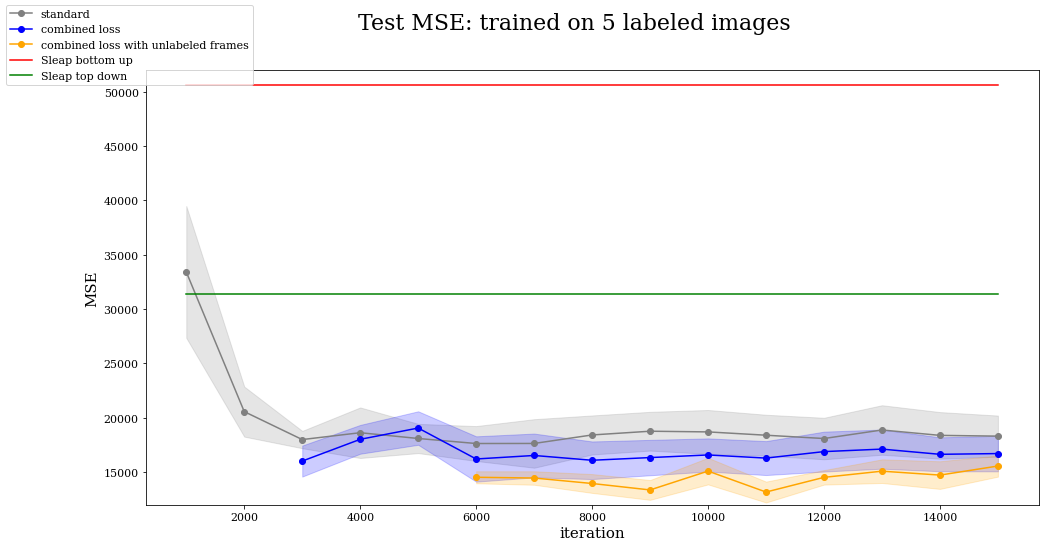

In [172]:
SMALL_SIZE = 11
MEDIUM_SIZE = 15
BIGGER_SIZE = 20
plt.rcParams.update({'font.size': 22})
plt.rc('legend', fontsize=12)    # legend fontsize
plt.rc('figure', titlesize=40)  # fontsize of the figure title
#plt.rc('font', 8)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
it_c = range(3000,15001,1000)
it1 = range(3000,15001,1000)
itu = range(6000,15001,1000)
ita = range(1000,15001,1000)
fig, axes = plt.subplots(1,1,figsize=(16,8))
ax = axes
plt.xlabel("iteration")
plt.ylabel("MSE")
fig.suptitle("Test MSE: trained on 5 labeled images ",fontsize = 22)
colors = ['r','b','y','g']

plt.plot(ita, sa, '-o', c='grey', label="standard")
plt.fill_between(ita, np.array(sa)-np.array(s_e), np.array(sa)+np.array(s_e),alpha = .2,color='grey')

plt.plot(it1, ca, '-o', c='blue', label="combined loss")
plt.fill_between(it1, np.array(ca)-np.array(c_e), np.array(ca)+np.array(c_e),alpha = .2,color='blue')

plt.plot(itu, va, '-o', c='orange', label="combined loss with unlabeled frames")
plt.fill_between(itu, np.array(va)-np.array(u_e), np.array(va)+np.array(u_e),alpha = .2,color='orange')

#plt.plot(itu, ca3, '-o', c='pink', label="beta=.001")
#plt.plot(itu, ca0, '-o', c='red', label="beta=.1")
#plt.plot(itu, ca1, '-o', c='green', label="beta=1")
#plt.plot(itu, b5a, '-o', c='orange', label="beta=.5")
#plt.plot(itu, ca3, '-o', c='pink', label="beta=.001")

plt.plot(ita, bu[0:15], c='red', label="Sleap bottom up")
plt.plot(ita, td[0:15], c='green', label="Sleap top down")
ax.set_ylim(top = 52000,bottom = 12000)
fig.legend(loc='upper left')
fig.savefig("all_5" +'.pdf')
plt.show()

In [167]:
frame_index = None



save_file = 'bee_5_standard.mp4'
fourcc = cv2.VideoWriter_fourcc(*'XVID')
dd1,dd2 = (test_ims[0].shape[0]),(test_ims[0].shape[1])
print(dd1,dd2)
out = cv2.VideoWriter(save_file, fourcc, 1.0, (dd2,dd1))
for im in test_ims:
    out.write(im)
    
out.release()


1440 2560
